In [1]:
## Plotting/other packages
import os
import h5py
import math
import time
from typing import Set, List, Dict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import diffrax as dfx
from diffrax import diffeqsolve, Dopri5, Tsit5, ODETerm, SaveAt, PIDController
import pprint as pp
import jax
from jax import jit, lax, grad, random, jacfwd, jacrev, jit
import jax.numpy as jnp
import equinox as eqx


from cdcm_utils.cdcm_jax import *
from cdcm import *
from duffing_oscillator import make_duff_osc_sys

/Users/smanikka/miniforge3/envs/py39env/lib/python3.9/site-packages/diffrax/adjoint.py:665: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  _loop_backsolve.defvjp(_loop_backsolve_fwd, _loop_backsolve_bwd)


#### Utilities ####

In [2]:
def plot_prediction(data_dict, sys, test_saver, t_data):
    x1_data = data_dict[sys.dho.x1]
    x2_data = data_dict[sys.dho.x2]
    x1_pred = fetch_save_data(
        path=f"{sys.name}/dho/x1",
        test_saver=test_saver,
    )
    x2_pred = fetch_save_data(
        path=f"{sys.name}/dho/x2",
        test_saver=test_saver,
    )
    fig, ax = plt.subplots(1,1, figsize = (10, 5), facecolor="w", edgecolor="k")
    ax.plot(t_data,x1_data,'c',label='x1_data')
    ax.plot(t_data, x2_data,'y',label='x2_data')
    ax.plot(t_data, x1_pred,'r--',label='x1 pred')
    ax.plot(t_data, x2_pred,'k-.',label='x2 pred')
    plt.legend()
    plt.show()


def get_simuln_result(sys, max_steps, data_dict):
    def set_ic():
        if data_dict:
            sns = list(data_dict.keys())
            for sn in sns:
                sn.value = data_dict[sn][0]
        
    file_name = "damped_simple_harmonic_egs.h5"

    if os.path.exists(file_name):
        os.remove(file_name)

    saving_frac = 1 # saving done every saving_frac*dt instant
    test_saver = SimulationSaver(
        file_name,
        sys,
        max_steps=math.ceil(max_steps/saving_frac)
    )
    simulator = Simulator(sys)

    now = time.time()
    simulator.add_event(0., set_ic)
    for i in range(max_steps):
        simulator.forward()
        if i%saving_frac==0:
            test_saver.save()
        simulator.transition()
    print('time taken (s)',time.time()-now)
    return test_saver


def fetch_save_data(path,test_saver,sp=''):
    res = test_saver.file_handler[path][:]
    if sp:
        np.savetxt(sp, res, delimiter=",")
        print('saved')
    return res

### cdcm system and simulation ###

In [3]:
dt = 0.01
max_steps = 250*2
to_s = 0.
tmax_s = max_steps*dt
t_data = np.arange(0.,max_steps*dt,dt)
force_data = np.cos(t_data)
input_dict = {"force":force_data}

input_data_df = pd.DataFrame(input_dict)
input_data_df.head()
input_data = {
    "data":input_data_df,
    "name":"input_sys",
}
kwargs = {"input_data":input_data}
duff_osc_sys = make_duff_osc_sys(
    dt = dt,
    name="duff_osc_sys",
    **kwargs,
)

time taken (s) 0.411898136138916


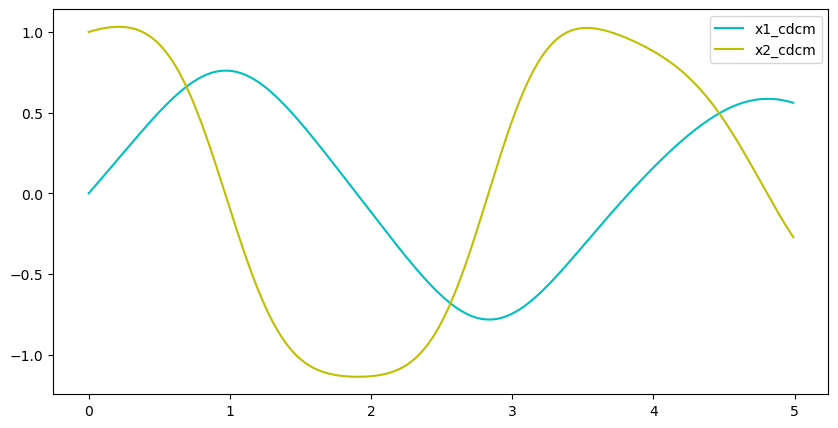

In [4]:

cdcm_simn_res = get_simuln_result(
    sys=duff_osc_sys,
    max_steps=max_steps,
    data_dict={}
)

fig, ax = plt.subplots(1,1, figsize = (10, 5), facecolor="w", edgecolor="k")
x1s = fetch_save_data(
            "duff_osc_sys/duff_osc/x1",
            cdcm_simn_res,
        )
x2s = fetch_save_data(
            "duff_osc_sys/duff_osc/x2",
            cdcm_simn_res,
        )
ax.plot(t_data,x1s,'c',label='x1_cdcm')
ax.plot(t_data, x2s,'y',label='x2_cdcm')
plt.legend()
plt.show()

### cdcm to diffrax ###

In [5]:
def get_vector_field(
        cdcm_sys: System,
        t_data: jax.Array,
        input_dict: Dict,
        dt: float,
        states=None,
    ):
    """
    This function constructes the vector_field (python function return
    ing temporal derivatives of states) corresponding to an
    arbitrary `cdcm_sys`.

    Arguments:
        cdcm_sys: CDCM System object of which vector field is required
        t_data: time instants at which input signals are available
        input_dict: Dictionary containing Input signals.it is of the form:
            {
                cdcm_data_node.name : data as array
                ....
            }
        dt: time step value for diffrax system
        states: (optional) A list of State nodes of `cdcm_sys` representing
            subgraph of the `cdcm_sys`. vector_field corresponding to this 
            function will be created. By default all state of `cdcm_sys` is
            considered.
    
    Return:
        vector_field: Callable Python function which returns temporal
            derivatives for diffrax.
        param_set: Set of Parameter nodes of the vector field
        vars_set: Set of Variable nodes with Forward functions of
            the vector field
        states_set: Set of State nodes with Transition functions
            of the vector field
        ordered_fn_list: A List consisting of the Forward and 
            Transition python functions sorted in topological order.

    Note
    state set may have more states than those in arg: states
    in a different order

    """
    

    #{"cdcm_data_node_name":interpolate_Texts(t_input,input_attr}
    input_signal = {}

    for input, data in input_dict.items():
        input_signal[input]= interpolate_Texts(t_data,data)
    if states is None:
        states = cdcm_sys.states.copy()
    
    (
        params_set, 
         vars_set,
         input_set,
         states_set,
    ) = get_params_vars_input_states_set(cdcm_sys,states)
    ordered_fn_list = get_ordered_fn_list(cdcm_sys,vars_set,states_set)
    (dict_of_fn_args_info_dict,
     dict_of_fn_res_info_dict) = get_fn_args_res_info(
                                    params_set,
                                    input_set,
                                    vars_set,
                                    states_set,
                                    ordered_fn_list,
                                )

    @jit 
    def vector_field(t,states,args):
        """
        states are as per states_set not the states
        given to get_dynamical_syst()
        """
        
        param_input_var_state_value_dict = {
            "params":[*args],
            "input":[
                input_signal[i.name].evaluate(t)
                for i in input_set],
            "vars":[None]*len(vars_set),
            "states":jnp.array(states),
            "next_state":[None]*len(states_set)
        }
        for fn in ordered_fn_list:
            fn_args_info = dict_of_fn_args_info_dict[fn.name]
            fn_args = []
            for _,v in fn_args_info.items():
                parent_type = v["parent_type"]
                local_idx = v["local_idx"]
                fn_arg = param_input_var_state_value_dict\
                [parent_type][local_idx]
                fn_args.append(fn_arg)
            fn_res = jnp.array([fn.func(*fn_args)])
            fn_res_info = dict_of_fn_res_info_dict[fn.name]
            
            for k,v in fn_res_info.items():
                child_type = v["child_type"]
                local_idx = v["local_idx"]
                param_input_var_state_value_dict\
                [child_type][local_idx] = fn_res[k]

        next_states = jnp.array(param_input_var_state_value_dict['next_state'])
        
        def get_time_derivs_lax(carry,x):
            new_state = next_states[x]
            state = param_input_var_state_value_dict['states'][x]
            time_deriv = (new_state-state)/dt
            return carry,time_deriv

        time_derivs = lax.scan(get_time_derivs_lax,None,xs=jnp.arange(len(states)))[1]
        return time_derivs
                    
    return vector_field, params_set, vars_set, states_set, ordered_fn_list

In [6]:
get_names = lambda x: [i.name for i in x]

In [7]:
vector_field, params_set, vars_set, states_set, ofl = get_vector_field(
duff_osc_sys,t_data,input_dict,dt,)
print(get_names(states_set))

['x2', 'x1']


In [8]:
args=[i.value for i in params_set]
args[get_names(params_set).index('dt')]=dt

In [9]:
key, subkey = random.split(random.PRNGKey(1234))
x0 = jnp.array([1., 0.])


import time
now = time.time()

@jit
def ODESolver(args):
    sol = diffeqsolve(
        ODETerm(vector_field),
        Tsit5(),
        #Dopri5(), 
        to_s, 
        tmax_s, 
        dt0=dt, #cdcm_sys.clock.dt.value,
        y0=x0,
        args=args, 
        saveat=SaveAt(ts=t_data),
        #AD through Solver graph, only reverse mode
        adjoint=dfx.RecursiveCheckpointAdjoint(checkpoints=200), 
        
        #Both forward and reverse mode. Prefer only if forward mode req else
        # RecursiveCheckpoint
        #adjoint=dfx.DirectAdjoint(),

        # used when solving towards a steady state. ie rhs=0
        #adjoint=dfx.ImplicitAdjoint(),
        
        # Continuous Adjoint ODE Solving backward in time. Only reverse mode.
        # Gradients will be approximate.
        # adjoint=dfx.BacksolveAdjoint(), 
        max_steps=8192
    )
    return sol

@jit
def soln_for_gradient(args):
    sol = run_dyn_sys(args)
    return sol.ys

sol = ODESolver(args)
print('time taken',time.time()-now) 

time taken 0.38527894020080566


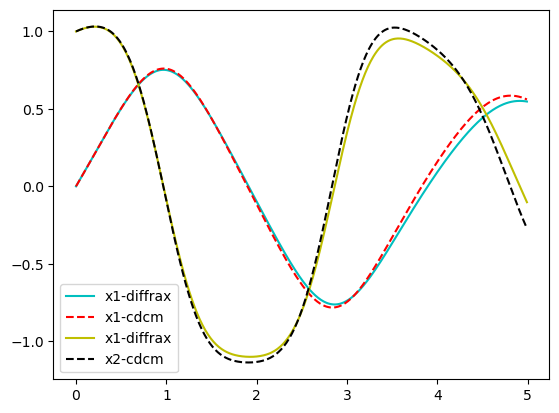

In [10]:
fig,ax=plt.subplots()
ax.plot(t_data,sol.ys[:,1],'c',label='x1-diffrax')
ax.plot(t_data,x1s,'--r',label='x1-cdcm')
ax.plot(t_data,sol.ys[:,0],'y',label='x1-diffrax')
ax.plot(t_data,x2s,'--k',label='x2-cdcm')
plt.legend()
plt.show()